In [1]:
!pip install plyfile -q

In [2]:
import os
import sys
from PIL import Image
from typing import NamedTuple
from scene.colmap_loader import read_extrinsics_text, read_intrinsics_text, qvec2rotmat, read_extrinsics_binary, read_intrinsics_binary, read_points3D_binary, read_points3D_text
from utils.graphics_utils import getWorld2View2, focal2fov, fov2focal
import numpy as np
import json
from pathlib import Path
from plyfile import PlyData, PlyElement
from utils.sh_utils import SH2RGB
from scene.dataset_readers import readColmapSceneInfo, sceneLoadTypeCallbacks
import torch

In [3]:
from scene import Scene, GaussianModel
from arguments import OptimizationParams, ModelParams
from argparse import ArgumentParser

## Memory Control

In [4]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

In [ ]:
clear_memory()

In [5]:
def initialize_model_and_db(dataset, opt):
    gaussians = GaussianModel(dataset.sh_degree, opt.optimizer_type)
    return Scene(dataset, gaussians), gaussians

In [6]:
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)

In [7]:
args = parser.parse_args([])

In [8]:
lp.source_path = "/home/jaoc/Desktop/Projects/3DSceneReconstruction/3DGS/gaussian-splatting/tandt_db/db/playroom/"

In [9]:
args_ = lp.extract(args)

In [10]:
args_.source_path, args_.images, args_.depths, args_.eval, args_.train_test_exp

('/home/jaoc/Desktop/Projects/3DSceneReconstruction/3DGS/gaussian-splatting',
 'images',
 '',
 False,
 False)

In [11]:
args_.source_path = "/home/jaoc/Desktop/Projects/3DSceneReconstruction/3DGS/gaussian-splatting/tandt_db/db/playroom"

In [12]:
args_.source_path, args_.images, args_.depths, args_.eval, args_.train_test_exp

('/home/jaoc/Desktop/Projects/3DSceneReconstruction/3DGS/gaussian-splatting/tandt_db/db/playroom',
 'images',
 '',
 False,
 False)

In [13]:
args_2 = op.extract(args)

## Initialization

In [14]:
scene, gaussians = initialize_model_and_db(args_, args_2)

Reading camera 225/225
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  37005


In [15]:
dir(gaussians)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_exposure',
 '_features_dc',
 '_features_rest',
 '_opacity',
 '_prune_optimizer',
 '_rotation',
 '_scaling',
 '_xyz',
 'active_sh_degree',
 'add_densification_stats',
 'capture',
 'cat_tensors_to_optimizer',
 'construct_list_of_attributes',
 'covariance_activation',
 'create_from_pcd',
 'denom',
 'densification_postfix',
 'densify_and_clone',
 'densify_and_prune',
 'densify_and_split',
 'exposure_mapping',
 'get_covariance',
 'get_exposure',
 'get_exposure_from_name',
 'get_features',
 'get_features_dc',
 'get_features_rest',
 'get_opacity',
 'get_rotation',
 'get_scaling',
 'get_xyz',
 'inverse_opacity_

In [16]:
dir(scene)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cameras_extent',
 'gaussians',
 'getTestCameras',
 'getTrainCameras',
 'loaded_iter',
 'model_path',
 'save',
 'test_cameras',
 'train_cameras']

## Gaussian Dimensions

#### Gaussians

In [17]:
def debug_tensor(tensor, name):
    """Helper function to print debug info of a tensor."""
    print(f"\n{name}:")
    if isinstance(tensor, torch.Tensor):
        print(f"  Shape: {tensor.shape}")
        print(f"  Size: {tensor.numel()} elements")
        print(f"  Data type: {tensor.dtype}")
        print(f"  Device: {tensor.device}")
        print(f"  Mean: {tensor.mean().item() if tensor.numel() > 0 else 'N/A'}")
    else:
        print(f"  Value: {tensor}")

def execute_gaussian_methods(gaussians):
    """Executes each method/property of the Gaussian object and prints debug info."""
    debug_tensor(gaussians.get_scaling, "Scaling")
    debug_tensor(gaussians.get_rotation, "Rotation")
    debug_tensor(gaussians.get_xyz, "XYZ Coordinates")
    debug_tensor(gaussians.get_features, "Features")
    debug_tensor(gaussians.get_features_dc, "Features DC (Colors)")
    debug_tensor(gaussians.get_features_rest, "Features Rest (SH Degrees)")
    debug_tensor(gaussians.get_opacity, "Opacity")
    debug_tensor(gaussians.get_exposure, "Exposure")
    try:
        debug_tensor(gaussians.get_covariance(), "Covariance")
    except Exception as e:
        print(f"\nError computing covariance: {e}")

In [18]:
gaussians._exposure.shape

torch.Size([225, 3, 4])

In [19]:
execute_gaussian_methods(gaussians)


Scaling:
  Shape: torch.Size([37005, 3])
  Size: 111015 elements
  Data type: torch.float32
  Device: cuda:0
  Mean: 0.07719158381223679

Rotation:
  Shape: torch.Size([37005, 4])
  Size: 148020 elements
  Data type: torch.float32
  Device: cuda:0
  Mean: 0.25

XYZ Coordinates:
  Shape: torch.Size([37005, 3])
  Size: 111015 elements
  Data type: torch.float32
  Device: cuda:0
  Mean: 0.9782591462135315

Features:
  Shape: torch.Size([37005, 16, 3])
  Size: 1776240 elements
  Data type: torch.float32
  Device: cuda:0
  Mean: -0.02806681953370571

Features DC (Colors):
  Shape: torch.Size([37005, 1, 3])
  Size: 111015 elements
  Data type: torch.float32
  Device: cuda:0
  Mean: -0.4490690529346466

Features Rest (SH Degrees):
  Shape: torch.Size([37005, 15, 3])
  Size: 1665225 elements
  Data type: torch.float32
  Device: cuda:0
  Mean: 0.0

Opacity:
  Shape: torch.Size([37005, 1])
  Size: 37005 elements
  Data type: torch.float32
  Device: cuda:0
  Mean: 0.10000002384185791

Exposure:


In [20]:
gaussians.max_radii2D.shape

torch.Size([37005])

In [21]:
gaussians.xyz_gradient_accum

tensor([])

## Gaussian Parameters

In [22]:
gaussians.training_setup(args_2)

#### Gradiente acumulado para cada una de la posiciones

In [23]:
gaussians.xyz_gradient_accum.shape

torch.Size([37005, 1])

In [24]:
gaussians.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-15
    foreach: None
    fused: None
    lr: 0.0013507627882063389
    maximize: False
    name: xyz
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-15
    foreach: None
    fused: None
    lr: 0.0025
    maximize: False
    name: f_dc
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-15
    foreach: None
    fused: None
    lr: 0.000125
    maximize: False
    name: f_rest
    weight_decay: 0

Parameter Group 3
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-15
    foreach: None
    fused: None
    lr: 0.025
    maximize: False
    name: opacity
    weight_decay: 0

Parameter Group 4
    amsgrad: False
    betas: (0.9, 0.9

## Gradients size

## Spectral Analysis from GT

In [34]:
viewpoint_stack = scene.getTrainCameras().copy()
type(viewpoint_stack), len(viewpoint_stack)

(list, 225)

In [35]:
viewpoint_indices = list(range(len(viewpoint_stack)))

#### Choosing a random camera

In [69]:
from random import randint
import matplotlib.pyplot as plt
import numpy as np

In [81]:
rand_idx = randint(0, len(viewpoint_indices) - 1)
viewpoint_cam = viewpoint_stack.pop(rand_idx)
rand_idx, viewpoint_cam

(137, Camera())

**Extraction and transformation of a random image**

In [82]:
gt_image = viewpoint_cam.original_image.cuda()
type(gt_image)

torch.Tensor

In [83]:
gt_image.shape

torch.Size([3, 832, 1264])

In [84]:
gt_image.device

device(type='cuda', index=0)

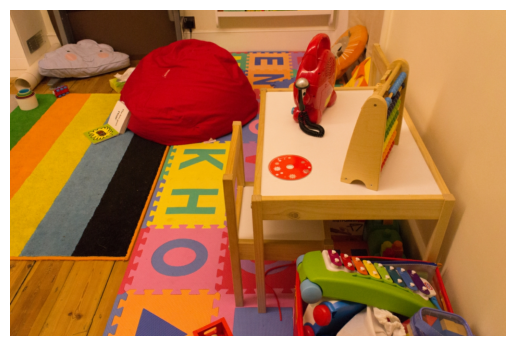

In [85]:
image_numpy = gt_image.permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)

# Mostrar la imagen
plt.imshow(image_numpy)
plt.axis("off")  # Ocultar ejes
plt.show()

**Fourier Transformations and other components**

In [86]:
gt_image_fft = torch.fft.fft2(gt_image)
magnitude_spectrum = torch.abs(gt_image_fft)
magnitude_spectrum_shifted = torch.fft.fftshift(magnitude_spectrum)
gt_image_fft.shape

torch.Size([3, 832, 1264])

**Amplitude**

In [87]:
magnitude_spectrum.shape, magnitude_spectrum_shifted.shape

(torch.Size([3, 832, 1264]), torch.Size([3, 832, 1264]))

In [88]:
maxi_1, mini_1, maxi_2, mini_2, maxi_3, mini_3 = magnitude_spectrum[0].max(), magnitude_spectrum[0].min(), magnitude_spectrum[1].max(), magnitude_spectrum[1].min(), magnitude_spectrum[2].max(), magnitude_spectrum[2].min()
maxi_1, mini_1, maxi_2, mini_2, maxi_3, mini_3

(tensor(705498.3125, device='cuda:0'),
 tensor(0.0052, device='cuda:0'),
 tensor(439269.2188, device='cuda:0'),
 tensor(0.0044, device='cuda:0'),
 tensor(222831.2812, device='cuda:0'),
 tensor(0.0049, device='cuda:0'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0044277487..13.466661].


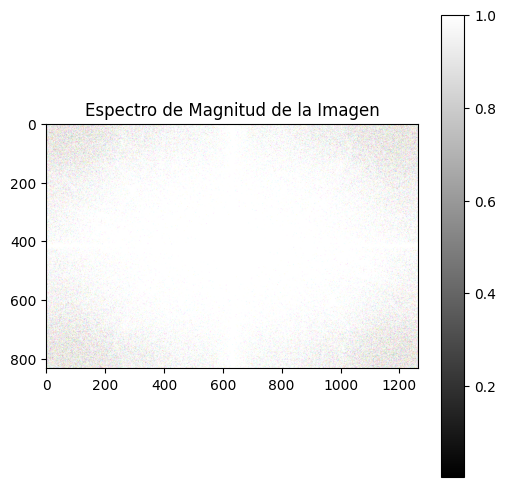

In [89]:
plt.figure(figsize=(6,6))
plt.imshow(torch.log(1 + magnitude_spectrum_shifted.permute(1, 2, 0)).cpu().numpy(), cmap='gray')
plt.colorbar()
plt.title("Espectro de Magnitud de la Imagen")
plt.show()

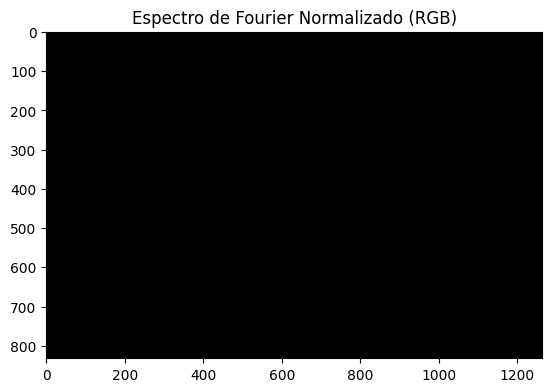

In [90]:
# Varianza muy alta!
magnitude_spectrum_normalized = (magnitude_spectrum - magnitude_spectrum.min()) / (magnitude_spectrum.max() - magnitude_spectrum.min())

# Opcional: Mostrar los tres canales combinados (RGB):
magnitude_spectrum_normalized = magnitude_spectrum_normalized.permute(1, 2, 0).cpu().numpy()
plt.imshow(magnitude_spectrum_normalized)
plt.title('Espectro de Fourier Normalizado (RGB)')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0044277487..13.466661].


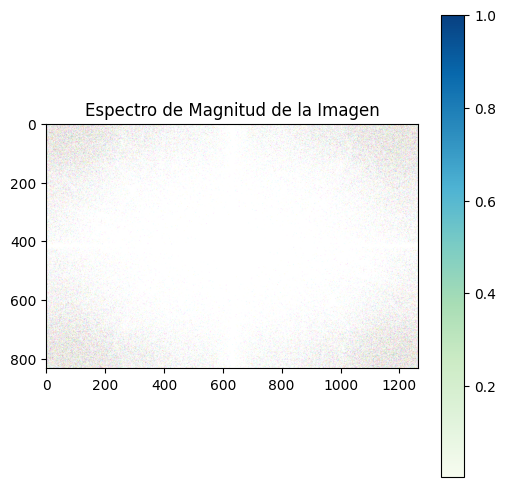

In [91]:
plt.figure(figsize=(6,6))
plt.imshow(torch.log(1 + magnitude_spectrum_shifted.permute(1, 2, 0)).cpu().numpy(), cmap='GnBu')
plt.colorbar()
plt.title("Espectro de Magnitud de la Imagen")
plt.show()

# Normalizacion

In [92]:
magnitude_spectrum_shifted = torch.fft.fftshift(magnitude_spectrum)

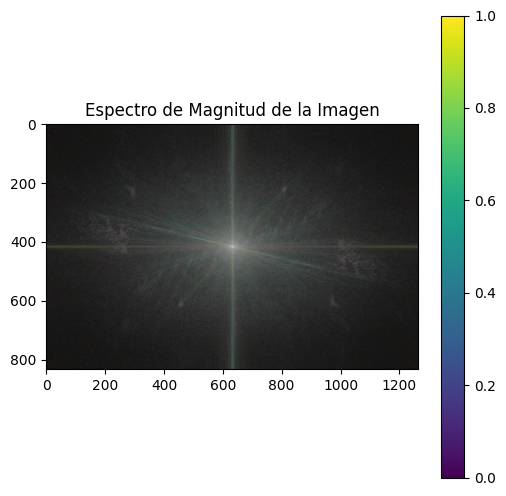

In [93]:
import matplotlib.pyplot as plt
import numpy as np
log_data = torch.log(1 + magnitude_spectrum_shifted).permute(1, 2, 0).cpu().numpy()
normalized_data = (log_data - log_data.min()) / (log_data.max() - log_data.min())

# Mostrar la imagen normalizada
plt.figure(figsize=(6, 6))
plt.imshow(normalized_data, cmap='viridis')
plt.colorbar()
plt.title("Espectro de Magnitud de la Imagen")
plt.show()

In [94]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

In [95]:
def calculate_frequency_thresholds(magnitude_spectrum_shifted, energy_threshold=0.9):
    """
    Calculate D0 (low-pass filter cutoff) and D (maximum significant frequency range)
    based on the energy distribution in the Fourier spectrum.
    
    Parameters:
    -----------
    magnitude_spectrum_shifted : torch.Tensor
        The shifted magnitude spectrum (DC component at center)
    energy_threshold : float, optional
        The energy percentage threshold for D0 (default: 0.90 or 90%)
        
    Returns:
    --------
    d0 : float
        The radius that contains energy_threshold% of the total energy
    d : float
        The radius that contains approximately 99.9% of the total energy
    """
    if len(magnitude_spectrum_shifted.shape) > 2:
        if len(magnitude_spectrum_shifted.shape) == 3:  # [C, H, W]
            magnitude_spectrum_shifted = magnitude_spectrum_shifted.mean(dim=0)
        else: 
            magnitude_spectrum_shifted = magnitude_spectrum_shifted.mean(dim=1)
    
    h, w = magnitude_spectrum_shifted.shape
    center_y, center_x = h // 2, w // 2
    
    y_coords, x_coords = torch.meshgrid(
        torch.arange(h, device=magnitude_spectrum_shifted.device), 
        torch.arange(w, device=magnitude_spectrum_shifted.device),
        indexing='ij'
    )
    
    distances = torch.sqrt((y_coords - center_y)**2 + (x_coords - center_x)**2)
    
    max_distance = torch.max(distances)
    
    # Create histogram of energy by distance
    num_bins = 100
    max_radius = min(center_y, center_x)
    radius_bins = torch.linspace(0, max_radius, num_bins+1)
    energy_by_radius = torch.zeros(num_bins, device=magnitude_spectrum_shifted.device)
    
    # Square the magnitude to get energy
    energy = magnitude_spectrum_shifted**2
    total_energy = torch.sum(energy)
    
    # Bin energy by radius
    for i in range(num_bins):
        radius_min = radius_bins[i]
        radius_max = radius_bins[i+1]
        mask = (distances >= radius_min) & (distances < radius_max)
        energy_by_radius[i] = torch.sum(energy[mask])
    
    # Calculate cumulative energy distribution
    cumulative_energy = torch.cumsum(energy_by_radius, dim=0) / total_energy
    
    # Find D0 (radius for energy_threshold% of energy)
    d0_bin = torch.nonzero(cumulative_energy >= energy_threshold)[0].item()
    d0 = radius_bins[d0_bin].item()
    
    # Find D (radius for 99.9% of energy)
    d_bin = torch.nonzero(cumulative_energy >= 0.999)[0].item()
    d = radius_bins[d_bin].item()
    
    return d0, d

In [96]:
def visualize_thresholds(magnitude_spectrum_shifted, d0, d):
    """
    Visualize the magnitude spectrum with the calculated thresholds
    
    Parameters:
    -----------
    magnitude_spectrum_shifted : torch.Tensor
        The shifted magnitude spectrum (DC component at center)
    d0 : float
        The D0 threshold (low-pass filter cutoff)
    d : float
        The D threshold (maximum significant frequency range)
    """
    # Convert to numpy for plotting
    if len(magnitude_spectrum_shifted.shape) > 2:
        # If we have a multichannel image, average across channels
        if len(magnitude_spectrum_shifted.shape) == 3:  # [C, H, W]
            mag_spectrum_np = magnitude_spectrum_shifted.mean(dim=0).cpu().numpy()
        else:  # [B, C, H, W]
            mag_spectrum_np = magnitude_spectrum_shifted.mean(dim=1).cpu().numpy()
    else:
        mag_spectrum_np = magnitude_spectrum_shifted.cpu().numpy()
    
    # Log scale for better visualization
    log_spectrum = np.log1p(mag_spectrum_np)
    
    # Normalize to [0, 1]
    normalized_spectrum = (log_spectrum - log_spectrum.min()) / (log_spectrum.max() - log_spectrum.min())
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(normalized_spectrum, cmap='viridis')
    
    # Get center coordinates
    h, w = normalized_spectrum.shape
    center_y, center_x = h // 2, w // 2
    
    # Add circles for D0 and D
    d0_circle = plt.Circle((center_x, center_y), d0, color='r', fill=False, linestyle='-', linewidth=2, label=f'D0={d0:.1f}')
    d_circle = plt.Circle((center_x, center_y), d, color='white', fill=False, linestyle='--', linewidth=2, label=f'D={d:.1f}')
    
    ax.add_patch(d0_circle)
    ax.add_patch(d_circle)
    
    # Add colorbar and legend
    plt.colorbar(im)
    ax.legend(loc='upper right')
    
    plt.title('Espectro de Magnitud con Umbrales D0 y D')
    plt.tight_layout()
    plt.show()
    
    # Show energy distribution
    h, w = magnitude_spectrum_shifted.shape[-2], magnitude_spectrum_shifted.shape[-1]
    center_y, center_x = h // 2, w // 2
    
    # Create a grid of coordinates
    y_coords, x_coords = torch.meshgrid(
        torch.arange(h, device=magnitude_spectrum_shifted.device), 
        torch.arange(w, device=magnitude_spectrum_shifted.device),
        indexing='ij'
    )
    
    # Calculate the distance from center for each pixel
    distances = torch.sqrt((y_coords - center_y)**2 + (x_coords - center_x)**2)
    
    # Create histogram of energy by distance
    num_bins = 100
    max_radius = min(center_y, center_x)
    radius_bins = torch.linspace(0, max_radius, num_bins+1)
    energy_by_radius = torch.zeros(num_bins, device=magnitude_spectrum_shifted.device)
    
    # Square the magnitude to get energy
    if len(magnitude_spectrum_shifted.shape) > 2:
        # Handle multichannel
        energy = magnitude_spectrum_shifted.mean(dim=0 if len(magnitude_spectrum_shifted.shape) == 3 else 1)**2
    else:
        energy = magnitude_spectrum_shifted**2
        
    total_energy = torch.sum(energy)
    
    # Bin energy by radius
    for i in range(num_bins):
        radius_min = radius_bins[i]
        radius_max = radius_bins[i+1]
        mask = (distances >= radius_min) & (distances < radius_max)
        energy_by_radius[i] = torch.sum(energy[mask]) / total_energy
    
    # Calculate cumulative energy
    cumulative_energy = torch.cumsum(energy_by_radius, dim=0)
    
    # Plot energy distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot energy distribution by radius
    radii = radius_bins[:-1].cpu().numpy()
    ax1.plot(radii, energy_by_radius.cpu().numpy())
    ax1.axvline(x=d0, color='r', linestyle='-', label=f'D0={d0:.1f}')
    ax1.axvline(x=d, color='green', linestyle='--', label=f'D={d:.1f}')
    ax1.set_xlabel('Radio desde el centro')
    ax1.set_ylabel('Energía normalizada')
    ax1.set_title('Distribución de Energía por Radio')
    ax1.legend()
    
    # Plot cumulative energy
    ax2.plot(radii, cumulative_energy.cpu().numpy())
    ax2.axvline(x=d0, color='r', linestyle='-', label=f'D0={d0:.1f} - 90% energía')
    ax2.axvline(x=d, color='green', linestyle='--', label=f'D={d:.1f} - 99.9% energía')
    ax2.axhline(y=0.9, color='r', linestyle=':', alpha=0.5)
    ax2.axhline(y=0.999, color='green', linestyle=':', alpha=0.5)
    ax2.set_xlabel('Radio desde el centro')
    ax2.set_ylabel('Energía acumulada')
    ax2.set_title('Energía Acumulada por Radio')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

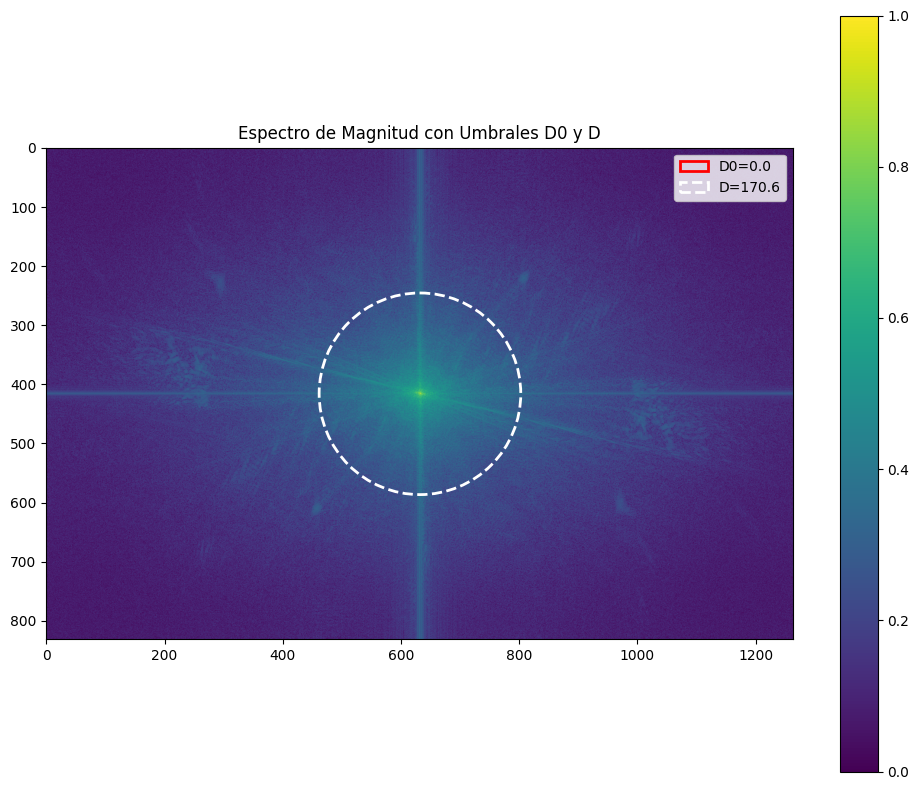

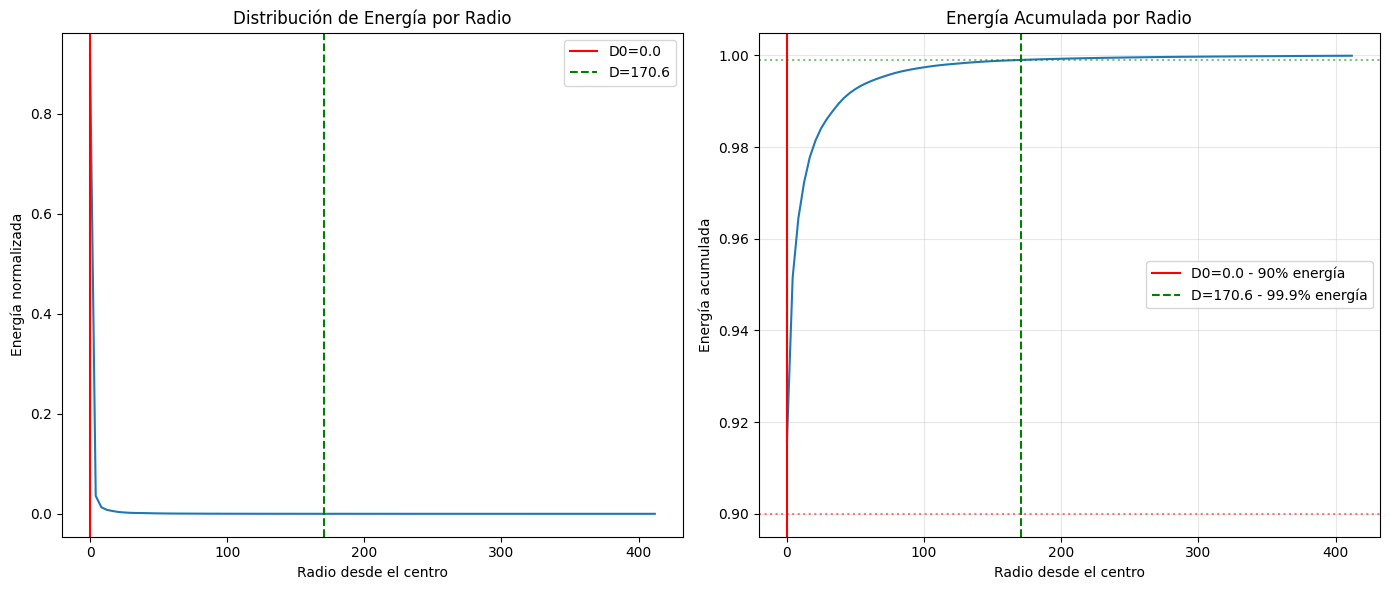

In [97]:
d0, d = calculate_frequency_thresholds(magnitude_spectrum_shifted)
visualize_thresholds(magnitude_spectrum_shifted, d0, d)

In [ ]:
shape = gt_image.shape[-2:]  # (H, W)
device = gt_image.device 
mask_low = create_frequency_mask(shape, D0, high_pass=False, device=device)

## Conclusiones
La varianza en la distribución de las frecuencias puede ser extremadamente alta.\
**Soluciones**
1. Aplicar la función logaritmo para reducir el 
2. Normalizar (Opcion a probar)